In [1]:
# Import necessary libraries
import fastscape
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xsimlab as xs

from bokeh.plotting import figure, output_file, save
from fastscape.models import basic_model
from fastscape.processes import SingleFlowRouter
from ipyfastscape import TopoViz3d
from landlab.components import FlowAccumulator
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import gaussian_filter
from xshade import hillshade




In [2]:
#读取netcdf文件
netcdf_path = r"C:\Users\Administrator\Videos\fastscape_test\minUp_test3_1\out_Minup_step.nc"
out_ds = xr.open_dataset(netcdf_path)
output_path = r"C:\Users\Administrator\Videos\fastscape_test\minUp_test3_1\topography__elevation.tif"
#导出topography__elevation为geotiff
dem = out_ds.isel(out=int(len(out_ds['topography__elevation']) * 0.75)).topography__elevation  #-1 or int(len(out_ds['topography__elevation']) * 0.75)
# 导出为GeoTIFF
dem = dem.rio.set_crs("EPSG:32648")
dem.rio.to_raster(output_path, driver='GTiff')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22196\2824809657.py:8: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  dem = dem.rio.set_crs("EPSG:32648")


In [3]:
import hvplot.xarray
%matplotlib inline
#hvplot是一个交互式绘图库，可以直接在jupyter notebook中显示交互式图形,设置比例为1:1
out_ds.topography__elevation.hvplot.image(x='x', y='y', cmap='RdBu_r', groupby='out', aspect='equal')


BokehModel(combine_events=True, render_bundle={'docs_json': {'c5604c60-e743-41a3-914a-9e5b0a4cf6a6': {'version…

In [4]:
from ipyfastscape import TopoViz3d, AppLinker
app1 = TopoViz3d(out_ds.load(), canvas_height=600, time_dim="out")
app1.show()

Output(layout=Layout(height='640px'))

In [5]:
out_ds

<xarray.Dataset> Size: 510MB
Dimensions:                (border: 4, out: 101, y: 300, x: 300, shape_yx: 2,
                            time: 1001)
Coordinates:
  * border                 (border) object 32B 'left' 'right' 'top' 'bottom'
  * out                    (out) float64 808B 0.0 2e+04 4e+04 ... 1.98e+06 2e+06
  * time                   (time) float64 8kB 0.0 2e+03 ... 1.998e+06 2e+06
  * x                      (x) float64 2kB 0.0 1.003e+03 ... 2.99e+05 3e+05
  * y                      (y) float64 2kB 0.0 1.003e+03 ... 2.99e+05 3e+05
Dimensions without coordinates: shape_yx
Data variables: (12/17)
    boundary__status       (border) <U11 176B 'core' 'core' 'fixed_value' 'core'
    drainage__area         (out, y, x) float64 73MB 2.013e+06 ... 2.013e+06
    erosion__rate          (out, y, x) float64 73MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    flow__basin            (out, y, x) float64 73MB 8.128e+04 ... 1.587e+04
    grid__length           (shape_yx) float64 16B 3e+05 3e+05
    grid__shape            (shape_yx) int32 8B 300 300
    ...                     ...
    spl__slope_exp         float64 8B 1.0
    spl__tol_abs           float64 8B 0.0001
    spl__tol_rel           float64 8B 0.0001
    terrain__slope         (out, y, x) float64 73MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    topography__elevation  (out, y, x) float64 73MB 0.6847 0.06084 ... 4.647e+03
    uplift__rate           (y, x) float64 720kB 0.0009069 0.0009072 ... 0.001311

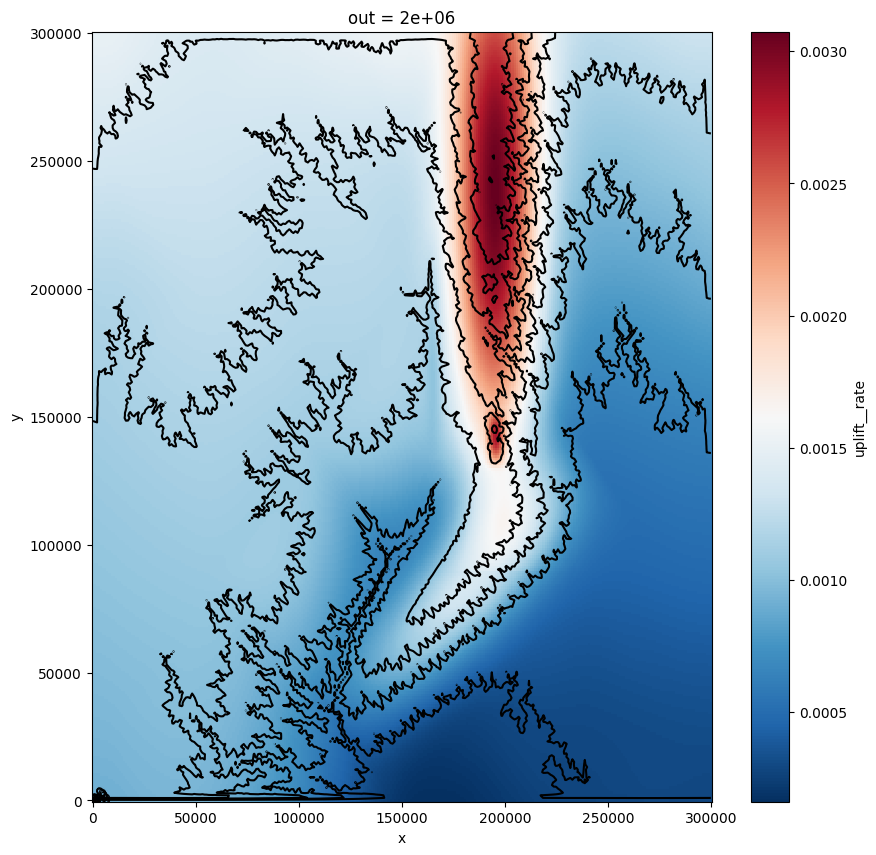

In [14]:
#绘制uplift__rate和等高线
fig, ax = plt.subplots(figsize=(10, 10))
out_ds.uplift__rate.plot(ax=ax, cmap='RdBu_r')
out_ds.topography__elevation.isel(out=-1).plot.contour(ax=ax, colors='k', levels=10)
#等高线注释
plt.clabel(plt.contour(out_ds.topography__elevation.isel(out=-1), colors='k', levels=10), fmt='%1.0f')
plt.show()

d:\OneDrive - zju.edu.cn\文档\MATLAB 代码\测试代码\xshade.py:37: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  result = da.groupby(time_dim).map(func, shortcut=False, **kwargs)
d:\OneDrive - zju.edu.cn\文档\MATLAB 代码\测试代码\xshade.py:37: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  result = da.groupby(time_dim).map(func, shortcut=False, **kwargs)
d:\OneDrive - zju.edu.cn\文档\MATLAB 代码\测试代码\xshade.py:37: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  result = da.groupby(time_dim).map(func, shortcut=False, **kwargs)


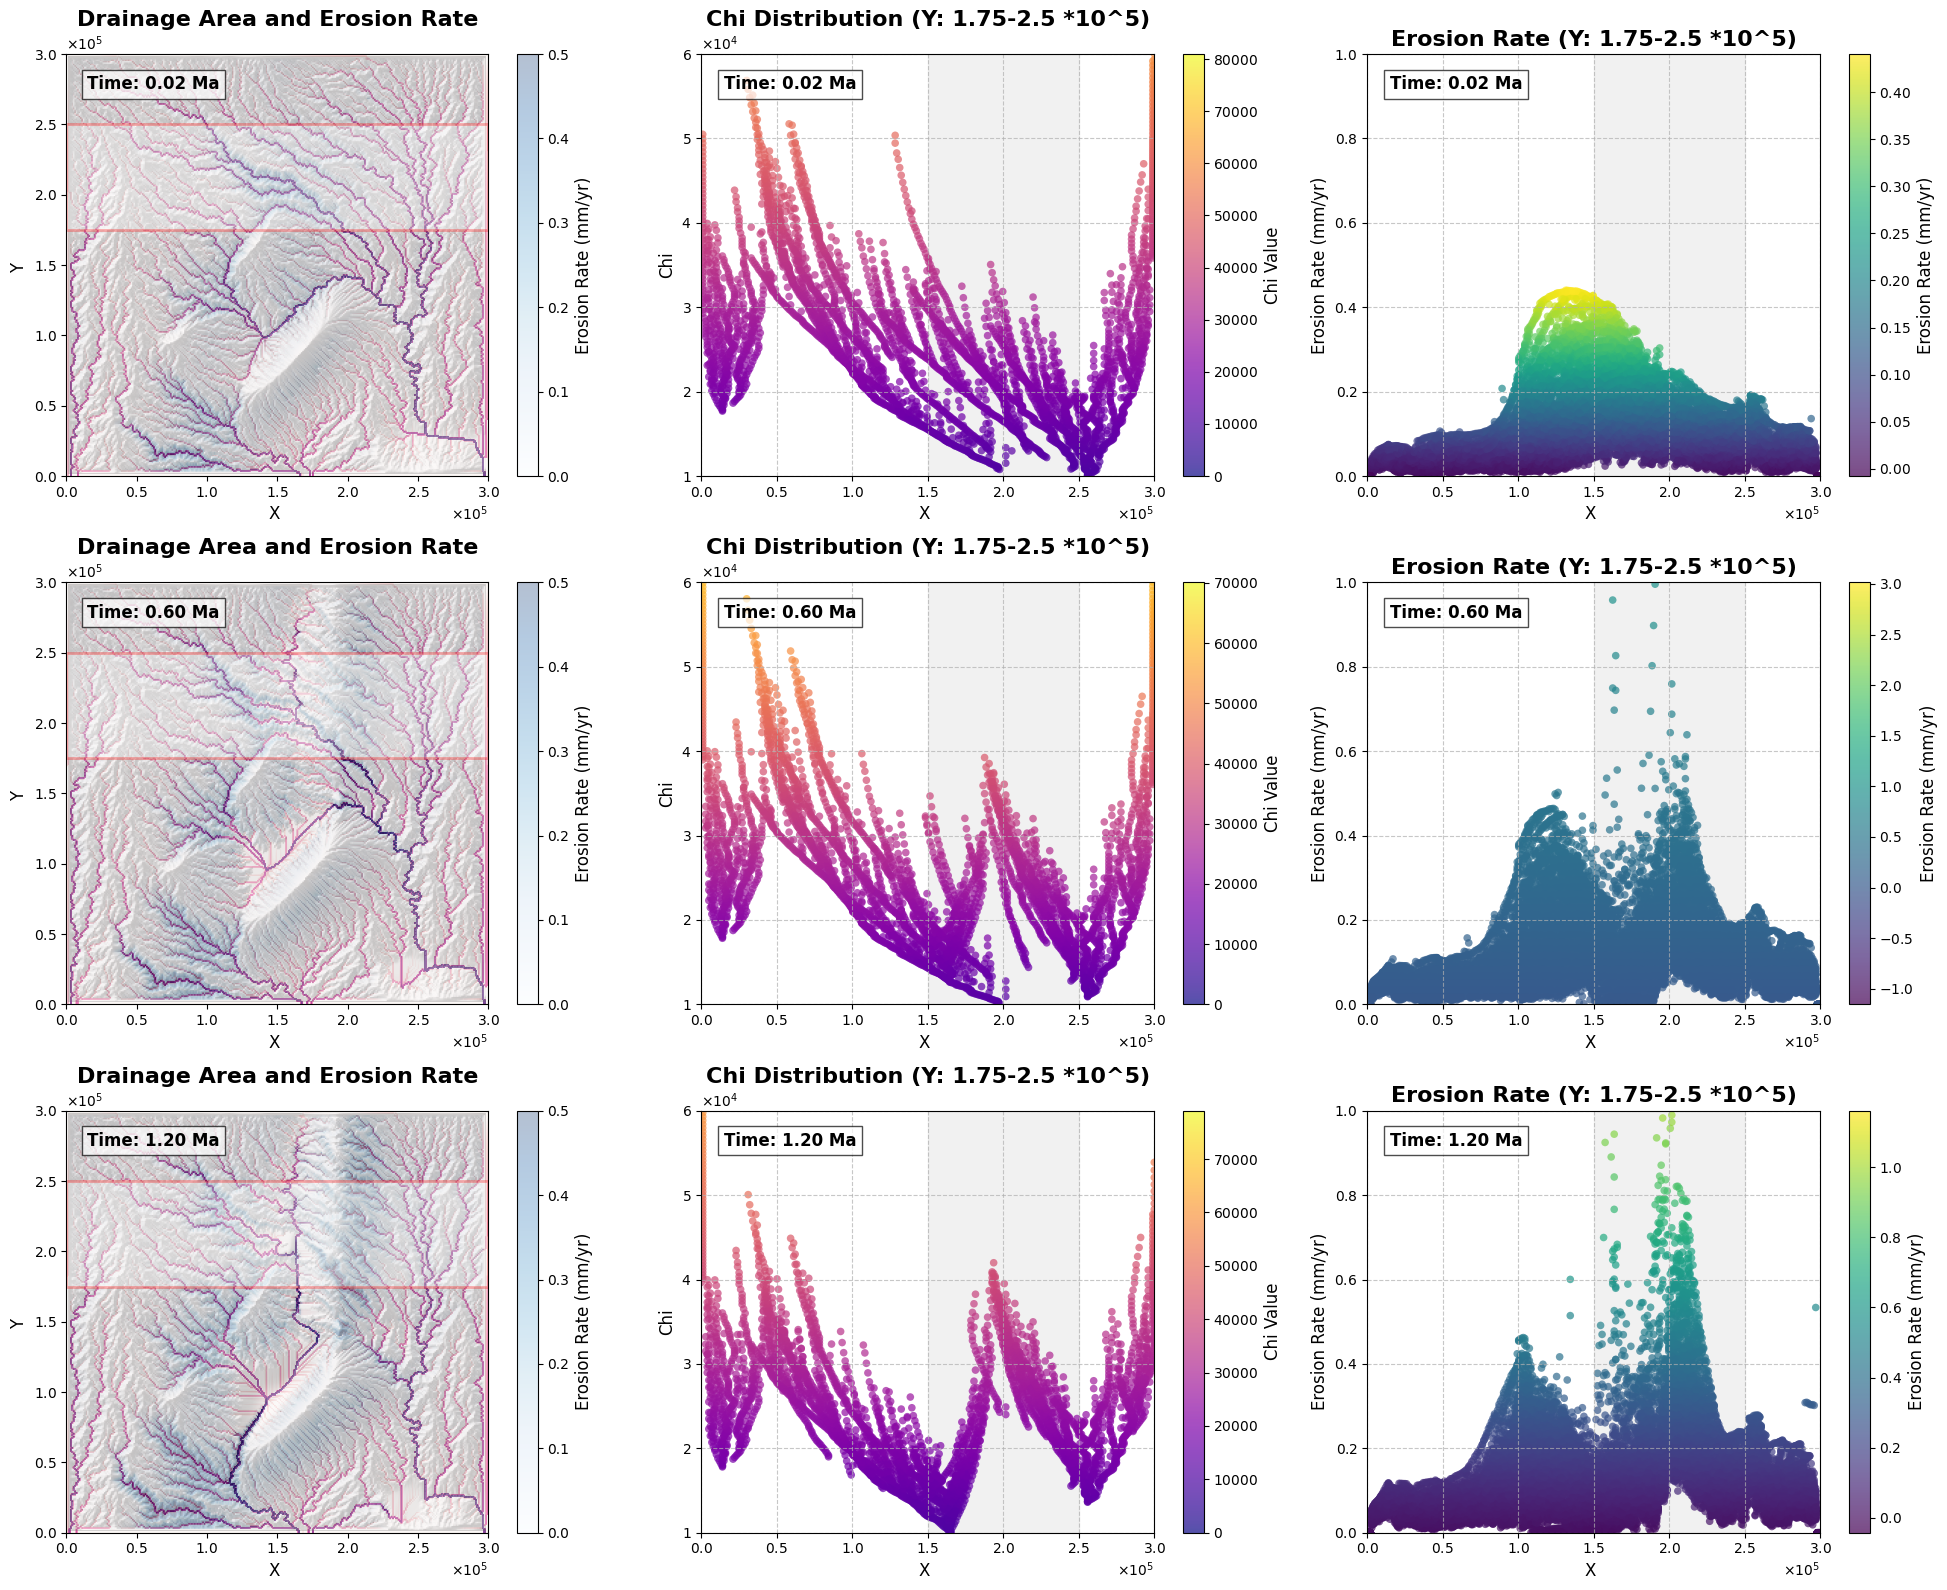

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
from xshade import hillshade
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter

# Set up the figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 16))

# Function to create plots for a given time step
def create_plots(time_step, ax_row):
    # Create hillshade
    hillshade_data = hillshade(out_ds, 'out').isel(out=time_step)

    # Plot drainage area distribution
    drainge_area = out_ds.drainage__area.isel(out=time_step)
    drainge_area_min, drainge_area_max = 1e7, 1e10

    norm = LogNorm(vmin=drainge_area_min, vmax=drainge_area_max)
    drainge_area_plot = ax_row[0].imshow(drainge_area, 
                                   extent=[out_ds.x.min(), out_ds.x.max(), out_ds.y.min(), out_ds.y.max()],
                                   cmap='RdPu', 
                                   origin='lower',
                                   norm=norm)

    # Add hillshade
    ax_row[0].imshow(hillshade_data, 
               extent=[out_ds.x.min(), out_ds.x.max(), out_ds.y.min(), out_ds.y.max()],
               cmap='gray', 
               alpha=0.3, 
               origin='lower')

    # Overlay erosion rate
    erosion_data = out_ds.erosion__rate.isel(out=time_step)  
    # Convert to mm/yr
    erosion_data = erosion_data * 1000
    erosion_norm = Normalize(vmin=0, vmax=0.5)
    erosion_plot = ax_row[0].imshow(erosion_data, 
                                    extent=[out_ds.x.min(), out_ds.x.max(), out_ds.y.min(), out_ds.y.max()],
                                    cmap='Blues', 
                                    alpha=0.3,
                                    norm=erosion_norm,
                                    origin='lower')

    # Add rectangle to show the band
    y_band_min, y_band_max = 175000, 250000
    rect = Rectangle((out_ds.x.min(), y_band_min), 
                     out_ds.x.max() - out_ds.x.min(), 
                     y_band_max - y_band_min,
                     fill=True, 
                     facecolor='white', 
                     edgecolor='red', 
                     alpha=0.3, 
                     linewidth=2)
    ax_row[0].add_patch(rect)

    # Customize left plot
    ax_row[0].set_title('Drainage Area and Erosion Rate', fontsize=16, fontweight='bold')
    ax_row[0].set_xlabel('X ', fontsize=12)
    ax_row[0].set_ylabel('Y ', fontsize=12)
    ax_row[0].tick_params(axis='both', which='major', labelsize=10)
    ax_row[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))


    # Add colorbar for Erosion Rate
    cbar_erosion = fig.colorbar(erosion_plot, ax=ax_row[0])
    cbar_erosion.set_label('Erosion Rate (mm/yr)', fontsize=12)
    cbar_erosion.ax.tick_params(labelsize=10)

    # Middle plot: Chi distribution scatter plot
    chi_data = out_ds.spl__chi.isel(out=time_step)
    chi_band = chi_data.sel(y=slice(y_band_min, y_band_max))

    x_mesh, y_mesh = np.meshgrid(chi_band.x, chi_band.y)

    # Determine color normalization method
    if (chi_band.values <= 0).any():
        norm = Normalize(vmin=chi_band.values.min(), vmax=chi_band.values.max())
    else:
        norm = LogNorm(vmin=max(chi_band.values.min(), 1e-10), vmax=chi_band.values.max())

    # Create scatter plot
    scatter = ax_row[1].scatter(x_mesh.flatten(), 
                          chi_band.values.flatten(), 
                          c=chi_band.values.flatten(),
                          s=30,
                          alpha=0.7,
                          cmap='plasma',
                          norm=norm,
                          edgecolors='none')

    # Add shaded area for orogen
    ax_row[1].axvspan(1.5e5, 2.5e5, color='lightgray', alpha=0.3, zorder=-1)

    # Customize middle plot
    ax_row[1].set_title(f'Chi Distribution (Y: {y_band_min/100000}-{y_band_max/100000} *10^5)', fontsize=16, fontweight='bold')
    ax_row[1].set_xlabel('X ', fontsize=12)
    ax_row[1].set_ylabel('Chi', fontsize=12)
    ax_row[1].set_xlim(out_ds.x.min(), out_ds.x.max())
    ax_row[1].set_ylim(1e4, 6e4)
    ax_row[1].tick_params(axis='both', which='major', labelsize=10)
    ax_row[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax_row[1].grid(True, linestyle='--', alpha=0.7)

    # Add colorbar to middle plot
    cbar2 = fig.colorbar(scatter, ax=ax_row[1])
    cbar2.set_label('Chi Value', fontsize=12)
    cbar2.ax.tick_params(labelsize=10)
    cbar2.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Right plot: Erosion rate scatter plot
    erosion_data = out_ds.erosion__rate.isel(out=time_step)*1000
    erosion_band = erosion_data.sel(y=slice(y_band_min, y_band_max))

    x_mesh, y_mesh = np.meshgrid(erosion_band.x, erosion_band.y)

    # Determine color normalization method for erosion rate
    if (erosion_band.values <= 0).any():
        norm_erosion = Normalize(vmin=erosion_band.values.min(), vmax=erosion_band.values.max())
    else:
        norm_erosion = LogNorm(vmin=max(erosion_band.values.min(), 1e-10), vmax=erosion_band.values.max())

    # Create scatter plot for erosion rate
    scatter_erosion = ax_row[2].scatter(x_mesh.flatten(), 
                                  erosion_band.values.flatten(), 
                                  c=erosion_band.values.flatten(),
                                  s=30,
                                  alpha=0.7,
                                  cmap='viridis',
                                  norm=norm_erosion,
                                  edgecolors='none')

    # Add shaded area for orogen
    ax_row[2].axvspan(1.5e5, 2.5e5, color='lightgray', alpha=0.3, zorder=-1)

    # Customize right plot
    ax_row[2].set_title(f'Erosion Rate (Y: {y_band_min/100000}-{y_band_max/100000} *10^5)', fontsize=16, fontweight='bold')
    ax_row[2].set_xlabel('X ', fontsize=12)
    ax_row[2].set_ylabel('Erosion Rate (mm/yr)', fontsize=12)
    ax_row[2].set_xlim(out_ds.x.min(), out_ds.x.max())
    ax_row[2].set_ylim(0, 1)
    ax_row[2].tick_params(axis='both', which='major', labelsize=10)
    ax_row[2].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[2].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_row[2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax_row[2].grid(True, linestyle='--', alpha=0.7)

    # Add colorbar to right plot
    cbar3 = fig.colorbar(scatter_erosion, ax=ax_row[2])
    cbar3.set_label('Erosion Rate (mm/yr)', fontsize=12)
    cbar3.ax.tick_params(labelsize=10)
    cbar3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Add timestep annotation in Ma
    time_in_ma = out_ds.out.values[time_step] / 1e6  # Convert to Ma
    for ax in ax_row:
        ax.text(0.05, 0.95, f'Time: {time_in_ma:.2f} Ma', 
                transform=ax.transAxes, 
                verticalalignment='top', 
                fontsize=12,
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

# Create plots for time_step 10, 30, and 50
create_plots(1, axes[0])
create_plots(30, axes[1])
create_plots(60, axes[2])

plt.tight_layout()
#导出为svg，分辨率为300dpi
fig.savefig(r'D:\OneDrive - zju.edu.cn\MR.Z  所有资料\Phd Period\论文\Drainage_Area_Chi_Erosion_Rate_Analysis.svg', dpi=300)
fig.savefig(r'D:\OneDrive - zju.edu.cn\MR.Z  所有资料\Phd Period\论文\Drainage_Area_Chi_Erosion_Rate_Analysis.png', dpi=300)
plt.show()